# Import data from the Kaggle site

Clearing out any old API tokens etc.

In [ ]:
! rm /root/.kaggle/*
! rmdir /root/.kaggle
! rm ./sample_data/*
! rmdir ./sample_data
! rm kaggle.json

rm: cannot remove './sample_data/*': No such file or directory
rmdir: failed to remove './sample_data': No such file or directory


Obtaining the Kaggle data

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 777 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Unzipping the data to the drive for persistence

In [ ]:
! unzip /content/lung-and-colon-cancer-histopathological-images.zip -d drive/My\ Drive/Colab\ Notebooks/Histopathology_Cancer_Detection/data

The dataset is large and in the interest of time, we will take only a subset of the images from each group

In [ ]:
import os
import shutil
import random

def get_file_list(input_dir):
    return [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]

def get_random_files(file_list, N):
    return random.sample(file_list, N)

def copy_files(random_files, input_dir, output_dir):
    for file in random_files:
        shutil.copy(os.path.join(input_dir, file), output_dir)

def main(input_dir, output_dir, N):
    file_list = get_file_list(input_dir)
    random_files = get_random_files(file_list, N)
    copy_files(random_files, input_dir, output_dir)

In [ ]:
main('/content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/data/lung_colon_image_set/colon_image_sets/colon_aca','/content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/data/lung_colon_image_set/colon_image_sets/colon/colon_aca',350)

In [ ]:
main('/content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/data/lung_colon_image_set/colon_image_sets/colon_n','/content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/data/lung_colon_image_set/colon_image_sets/colon/colon_n',350)

# The model building, training and evaluating happens here

Imports and such (Colab seems to have fast ai preloaded - how nice)

In [ ]:
from fastai import *
from fastai.vision import *

from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

from google.colab import files
from IPython.display import Image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Suppressing warnings: not always recommended, but in this case, it is to deal with a known PyTorch issue

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

Creating DataBunch from the images of the Kaggle dataset

(['colon_aca', 'colon_n'], 2, 560, 140)

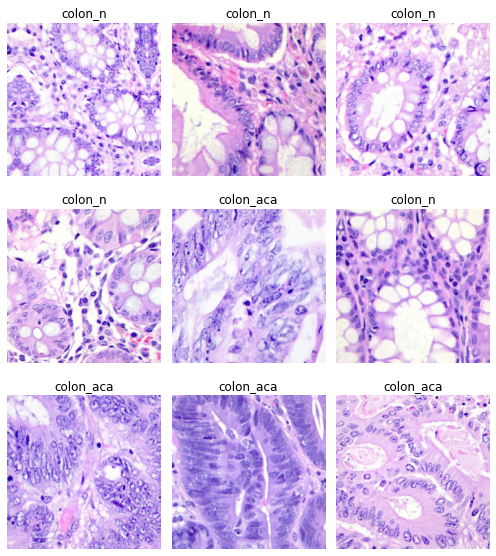

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder('/content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/data/lung_colon_image_set/colon_image_sets/colon', train=".", valid_pct=0.2,
         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
#ds_tfms=get_transforms(),     

# Verify data
data.classes
data.show_batch(rows=3, figsize=(7,8))
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

Use a pretrained model - in this case we use ResNet-34, but given the fact that we have Colab's TPU power at our disposal, we could try to use the more high end models at some point

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.611063,0.157432,0.050000,00:35
1,0.377806,0.040926,0.007143,00:38
2,0.268549,0.033396,0.007143,00:36
3,0.214851,0.036316,0.014286,00:36


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


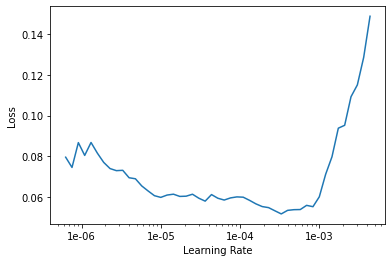

In [ ]:
learn = cnn_learner(data, models.squeezenet1_1, metrics=error_rate)
learn.fit_one_cycle(4)
learn.save('stage-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


In [5]:
learn.fit_one_cycle(2, max_lr=slice(3e-6,3e-4))
learn.save('/content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.104671,0.036802,0.007143,00:51
1,0.077835,0.024838,0.007143,00:50


In [6]:
learn.load('/content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (560 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
colon_n,colon_n,colon_n,colon_n,colon_n
Path: /content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/data/lung_colon_image_set/colon_image_sets/colon;

Valid: LabelList (140 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
colon_n,colon_aca,colon_aca,colon_n,colon_n
Path: /content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/data/lung_colon_image_set/colon_image_sets/colon;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 

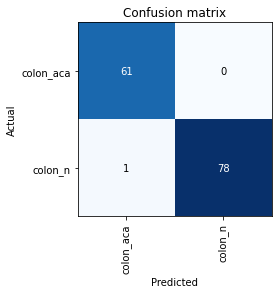

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [9]:
classes = ['colon_aca', 'colon_n']
data2 = ImageDataBunch.single_from_classes('/content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/data/lung_colon_image_set/colon_image_sets/colon', classes,  size=224).normalize(imagenet_stats)
learn = cnn_learner(data2, models.squeezenet1_1)
learn.load('/content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/data/lung_colon_image_set/colon_image_sets/colon;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/drive/My Drive/Colab Notebooks/Histopathology_Cancer_Detection/data/lung_colon_image_set/colon_image_sets/colon;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

In [10]:
from fastai.vision import *
uploaded = files.upload()
file1 = list(uploaded.keys())[0]
img = open_image(file1)
pred_class,pred_idx,outputs = learn.predict(img)
learn.data.classes[np.argmax(outputs)]

Saving colonn3.jpeg to colonn3.jpeg


'colon_n'

In [ ]:
type(img)

numpy.ndarray